# Use-case on collaborative filtering

Collaborative filtering is a family of methods where the output is a ranked list of items in the order of their relevance to the user taking into account the interactions of __similar__ users.

The workflow consists of two main steps:

 * Determine the similarity of users
 * Using the set of similar users calculate the ratings missing items
 
The model families can be groupped to two categories:

 1. Similarity based methods
 2. Model based methods
 
 
## Similarity based methods

Let's use the following user item matrix as an example. 4 users are in the rows and and 3 items are in the columns:

In [1]:
import numpy as np

ui = np.array([[5, np.nan, 4, 1, np.nan],
               [np.nan, 3, np.nan, 3, 5],
               [np.nan, 2, 4, 4, 1],
               [4, 4, 5, np.nan, np.nan],
               [2, 4, np.nan, 5, 2]])
ui

array([[ 5., nan,  4.,  1., nan],
       [nan,  3., nan,  3.,  5.],
       [nan,  2.,  4.,  4.,  1.],
       [ 4.,  4.,  5., nan, nan],
       [ 2.,  4., nan,  5.,  2.]])

(NOTE: indexing of users and items start with 0)

Integers in the matrix represent the explicit preference/rating of the users. What [measures](http://www.benfrederickson.com/distance-metrics/) shall can pick to measure the similarity between users?

__Jaccard distance__: intersection of two sets of items where the result is the number of items rated by both users but normalized by the size of intersection (avoids bias)

In [2]:
def jaccard(a, b):
    intersection = float(len(set(a).intersection(set(b))))
    return intersection / (len(a) + len(b) - intersection)

def get_set_of_items(ui, id):
    uij = np.argwhere(np.invert(np.isnan(ui)))
    return set(uij[uij[:, 0] == id][:,1])

In [3]:
a = get_set_of_items(ui, 0)
b = get_set_of_items(ui, 3)
jaccard(a, b)

0.5

In [4]:
c = get_set_of_items(ui, 2)
jaccard(c, b)

0.4

__Eucladian distance__: distance between two points in the *Eucladian* plane.
$$
d(\textbf{x}, \textbf{y}) = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^2)}
$$

Let's pick users 3 and 4:

In [5]:
u3 = ui[3,:2]
u4 = ui[4,:2]
print('User 3: ', u3)
print('User 4: ', u4)

from scipy import spatial

spatial.distance.euclidean(u3, u4)

User 3:  [4. 4.]
User 4:  [2. 4.]


2.0

In [6]:
spatial.distance.euclidean(u3, np.array([2,2]))

2.8284271247461903

(0.0, 6.0)

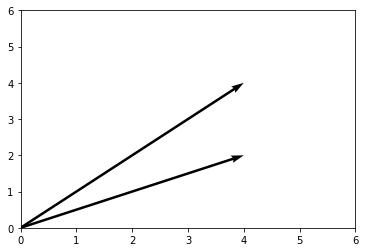

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

orig = np.array([[0, 0], [0, 0]])
plt.quiver(*orig, u3, u4, angles='xy', scale_units='xy', scale=1)
plt.xlim(0, 6)
plt.ylim(0, 6)

__Cosine similarity__: The higher the angle between two vectors the higher the value:

$$
\cos ({\bf u_1},{\bf u_2})= {{\bf u_1} {\bf u_2} \over \|{\bf u_1}\| \|{\bf u_2}\|},
$$
which returns a value in [-1, 1].

__Note__ that the cosine distance in the SciPy packge returns $$ 1- \cos ({\bf u_1},{\bf u_2})$$

In [8]:
1 - spatial.distance.cosine(u3, u4)

0.9486832980505138

In [9]:
1 - spatial.distance.cosine(u3, np.array([4,1]))

0.8574929257125441

__Centered cosine similarity__: Looking at the user-item matrix the natural question arrives how to treat the non-rated items by similar users. Furthermore, note that the users expresses their preferences at different "levels". Some are more critical in general (though raters) with all items (gives rather lower ratings for everything) while others tend to give hither ratings in general. So we see that there is a need to remove this type of bias from the similarity measures. To solve boths of these problems we can center the ratings by substracting the averge user rating per person. Centered/average ratings per use can be also used to impute missing ratings of the similar users. By doing so the centered average of all users will be 0.

Let's see how does it looks like in case of cosine similarity, we use user1 and user2 in the example:

In [10]:
ui_centered = ui - np.nanmean(ui, axis = 1, keepdims = True)
ui_centered = np.nan_to_num(ui_centered)
# Calc cosine similarity on centered user-item matrix
1 - spatial.distance.cosine(ui_centered[3,:], ui_centered[4,:])

0.07856742013183848

In [ ]:
ui_cen

In [11]:
ui_centered

array([[ 1.66666667,  0.        ,  0.66666667, -2.33333333,  0.        ],
       [ 0.        , -0.66666667,  0.        , -0.66666667,  1.33333333],
       [ 0.        , -0.75      ,  1.25      ,  1.25      , -1.75      ],
       [-0.33333333, -0.33333333,  0.66666667,  0.        ,  0.        ],
       [-1.25      ,  0.75      ,  0.        ,  1.75      , -1.25      ]])

Negative similarity makes sense in case of user1 and user2 as they rated item1 pretty differently. The centered cosine similarty is also referred in the literature as equal to the Person correlation, let's check it:

In [12]:
from scipy.stats import pearsonr
pearson = pearsonr(ui_centered[3,:], ui_centered[4,:])
print('\nPearson corr: ', pearson[0])
print('p-value: pearson[1]')


Pearson corr:  0.07856742013183857
p-value: pearson[1]


## Calculating ratings

Now that we have a similarty measure between users, we can calculate ratings of non-rated items of each user. A users "predicted" rating for a given item will be the average rating of those outer users who are similar. In our method we weight the other user's rating with the similarity measure:

$$
R_u = (\sum_{u=1}^n R_u*S_u)/(\sum_{u=1}^n S_u)
$$
where R is the given user rating, n is the number of __similar__ users and S is the similarity measure, in our case the centered cosine similarity. For the sake of simplicity we define similar users where the __cosine value is > 0__, therefore we need to floor the similarty matrix at zero

Let's implement this in our example:

In [13]:
# Calculte centered cosine similarity matrix
# Note we cheat here as we use the Numpy Pearson corr func ;)
simmat = np.corrcoef(ui_centered)
# floor similarty matrix
simmat[simmat < 0] = 0

In [14]:
# Get user-item pairs where there is no rating
no_rating = np.argwhere(np.isnan(ui))
no_rating = list(map(tuple, no_rating))
print('\nUser-item pairs where there is no rating: ', no_rating)


User-item pairs where there is no rating:  [(0, 1), (0, 4), (1, 0), (1, 2), (2, 0), (3, 3), (3, 4), (4, 2)]


In [15]:
out = ui.copy()
print('\nOriginal user-item matrix: \n' + '-'*100 + '\n', ui)
ui[np.isnan(ui)] = 0
np.fill_diagonal(simmat, 0)
for u, i in no_rating:
    rating = np.dot(ui[:, i], simmat[:, u]) / np.sum(simmat[:, u])
    out[u, i] = rating
print('\nModified similarity matirx: \n' + '-'*100 + '\n', simmat)
print('\nPredicted user-item matrix: \n' + '-'*100 + '\n', out)


Original user-item matrix: 
----------------------------------------------------------------------------------------------------
 [[ 5. nan  4.  1. nan]
 [nan  3. nan  3.  5.]
 [nan  2.  4.  4.  1.]
 [ 4.  4.  5. nan nan]
 [ 2.  4. nan  5.  2.]]

Modified similarity matirx: 
----------------------------------------------------------------------------------------------------
 [[0.         0.32357511 0.         0.         0.        ]
 [0.32357511 0.         0.         0.16666667 0.        ]
 [0.         0.         0.         0.51068823 0.56481481]
 [0.         0.16666667 0.51068823 0.         0.07856742]
 [0.         0.         0.56481481 0.07856742 0.        ]]

Predicted user-item matrix: 
----------------------------------------------------------------------------------------------------
 [[5.         3.         4.         1.         5.        ]
 [4.6600317  3.         4.3399683  3.         5.        ]
 [2.94967324 2.         4.         4.         1.        ]
 [4.         4.         

__Note__ that we can repeat the same exercise starting with __similarty of items__ instead of similarty of users.

Collaborative filtering methods based on similarity matrices suffers from the huge computational expense in case of large user-item matrices. Real life examples show that the user-item matrix is typically sparse: in this case dimensionality reduction methods come handy. Model based recommendation systems mostly a variant of __matrix factorization__ methods.

## Model based approaches

In this section we introduce two popular matrix factorization approaches:

 * Alternating Least Squares method
 * Bayesian Personalized Ranking method
 
### ALS
 
We use a well known __Last.fm__ dataset and [Ben Frederickson](https://github.com/benfred)'s `implicit` package to demonstrate ALS.

In [16]:
import pandas as pd

data = pd.read_table("lastfm-dataset-360k/usersha1-artmbid-artname-plays.tsv", 
                     usecols=[0, 2, 3], 
                     names=['user', 'artist', 'plays'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17535655 entries, 0 to 17535654
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   user    object
 1   artist  object
 2   plays   int64 
dtypes: int64(1), object(2)
memory usage: 401.4+ MB


In [18]:
data = data.iloc[:10000,:]
data

,user,artist,plays
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
...,...,...,...
9995,00243799d78e58fcf6869efc5232b5e776b18434,the appleseed cast,39
9996,00243799d78e58fcf6869efc5232b5e776b18434,natural snow buildings,37
9997,00243799d78e58fcf6869efc5232b5e776b18434,at the drive-in,35
9998,00243799d78e58fcf6869efc5232b5e776b18434,keelhaul,35


In [19]:
import implicit
from scipy.sparse import coo_matrix
from implicit.nearest_neighbours import bm25_weight

We use sparse matrix classes from `scipy.sparse` to represent our dataset in a memory efficient way. __COOrdinte sparse matrix__ requires the coordinates of non-zero elements.

In [20]:
# Map each artist and user to a unique numeric value
data['user'] = data['user'].astype("category")
data['artist'] = data['artist'].astype("category")

# Create a sparse matrix of all the artist/user/play triples
plays = coo_matrix((data['plays'].astype(float), 
                      (data['artist'].cat.codes, 
                      data['user'].cat.codes)))

We train a model with 50 factors and transform the play counts as the implicit ratings with [__BM25__](https://www.benfrederickson.com/distance-metrics/) weights. It is a ranking function, which ensures that the active listeners are not overrepresented compared to those who listen just to a couple of songs.

In [21]:
# Initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.02)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(bm25_weight(plays))

  0%|          | 0/15 [00:00<?, ?it/s]

In [22]:
# Recommend items for a user
user_items = plays.T.tocsr()

userid = 42
recommendations = model.recommend(userid, user_items)
for artistid, score in recommendations[:10]:
    print("%s\t%s\t%s\n" % (data['user'][userid], data['artist'][artistid], score))

00000c289a1829a808ac09c00daf10bc3c4e223b	metallica	1.0623744

00000c289a1829a808ac09c00daf10bc3c4e223b	oasis	0.92825145

00000c289a1829a808ac09c00daf10bc3c4e223b	antonio carlos jobim & astrud gilberto	0.85643005

00000c289a1829a808ac09c00daf10bc3c4e223b	the killers	0.8208675

00000c289a1829a808ac09c00daf10bc3c4e223b	disturbed	0.78080195

00000c289a1829a808ac09c00daf10bc3c4e223b	the automatic	0.734434

00000c289a1829a808ac09c00daf10bc3c4e223b	josé gonzález	0.7068355

00000c289a1829a808ac09c00daf10bc3c4e223b	tool	0.7010291

00000c289a1829a808ac09c00daf10bc3c4e223b	dark angel	0.67965066

00000c289a1829a808ac09c00daf10bc3c4e223b	snow patrol	0.6700312

